# Approximating a double pendulum

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


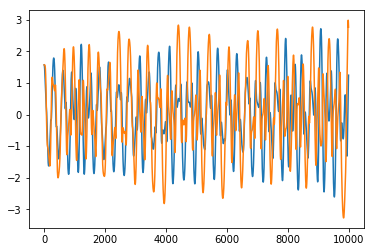

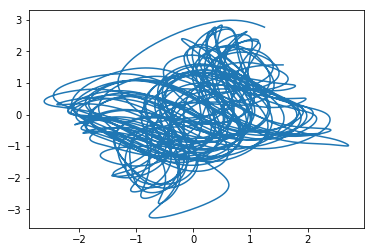

In [22]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 1, 1
m1, m2 = 1, 1
# The gravitational acceleration (m.s-2).
g = 9.81

def deriv(y, t, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (m2*g*np.sin(theta2) - m2*s*(L1*z1**2*c + L2*z2**2) -
             (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
    theta2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
             m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
    return theta1dot, z1dot, theta2dot, z2dot

# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 100, 0.01
t = np.arange(0, tmax+dt, dt)
# Initial conditions.
y0 = [np.pi/2, 0, np.pi/2, 0]

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))
# Unpack z and theta as a function of time
theta1, theta2 = y[:,0], y[:,2]

# Convert to Cartesian coordinates of the two bob positions.
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

plt.plot(theta1)
plt.plot(theta2)
theta_pair = [[x[0], x[1]] for x in zip(theta1, theta2)]
data = theta_pair
plt.figure()
plt.plot(theta1, theta2)

In [4]:
# hyperparameters
DATA_DIM = 2
N_PREV = 50 # number of previous steps used to predict the next step

In [5]:
def _load_data(data, n_prev=N_PREV):
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data[i:i+n_prev])
        docY.append(data[i+n_prev])
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(df) * (1 - test_size)))

    X_train, y_train = _load_data(df[0:ntrn])
    X_test, y_test = _load_data(df[ntrn:])

    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.2)

In [6]:
# define model structure
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=False), input_shape=(None, 2)))
# model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
# model.add(Dense(units=10, activation="selu"))
model.add(Dense(units=2, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [7]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1)

Train on 7155 samples, validate on 796 samples
Epoch 1/20
7155/7155 [==============================] - 4s 604us/step - loss: 0.2445 - val_loss: 0.0116
Epoch 2/20
7155/7155 [==============================] - 4s 556us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 3/20
7155/7155 [==============================] - 4s 553us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/20
7155/7155 [==============================] - 4s 552us/step - loss: 7.4567e-04 - val_loss: 0.0012
Epoch 5/20
7155/7155 [==============================] - 4s 549us/step - loss: 5.8185e-04 - val_loss: 9.6476e-04
Epoch 6/20
7155/7155 [==============================] - 4s 548us/step - loss: 4.7154e-04 - val_loss: 8.1710e-04
Epoch 7/20
7155/7155 [==============================] - 4s 546us/step - loss: 3.8477e-04 - val_loss: 6.4044e-04
Epoch 8/20
7155/7155 [==============================] - 4s 545us/step - loss: 3.2396e-04 - val_loss: 5.9952e-04
Epoch 9/20
7155/7155 [==============================] - 4s 544us/step - loss: 2.7958e

In [21]:
# evaluate model fit
score = model.evaluate(X_test, y_test)
print('Test score:', score)

1950/1950 [==============================] - 0s 216us/step
Test score: 0.001995622305503975


In [9]:
print(X_test.shape)

(1950, 50, 2)


In [19]:
# perform modelling
X_model = X_test[0]
modelled_data = []
dims = 1, X_model.shape[0], X_model.shape[1]
for i in range(len(y_test)):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(next_step[0])
    X_model = np.append(X_model[1:], next_step, axis=0)
modelled_data = np.array(modelled_data)

(1950, 2)
(1950, 2)


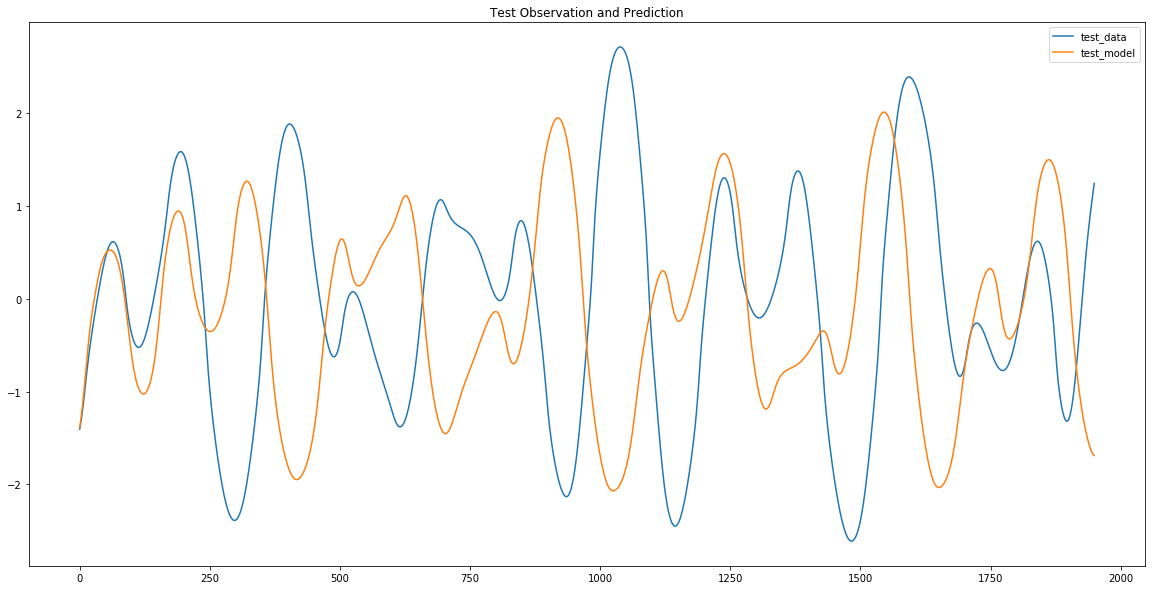

In [20]:
print(modelled_data.shape)
print(y_test.shape)
plt.figure(figsize=(20,10))
plt.plot(y_test[:,0], label='test_data')
plt.plot(modelled_data[:,0], label='test_model')
plt.title('Test Observation and Prediction')
plt.legend()

In [13]:
# visualize predictions
test_prediction = model.predict(X_test)

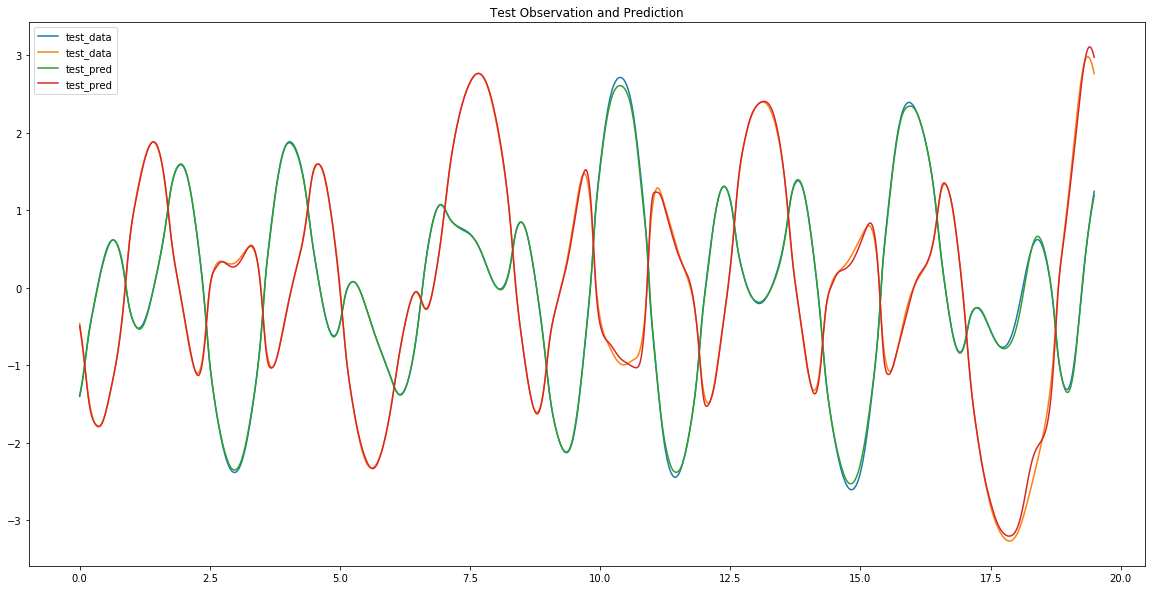

In [27]:
t_test = np.arange(0, len(y_test)*dt, dt)
plt.figure(figsize=(20,10))
plt.plot(t_test, y_test, label='test_data')
plt.plot(t_test, test_prediction, label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

In [15]:
train_prediction = model.predict(X_train)

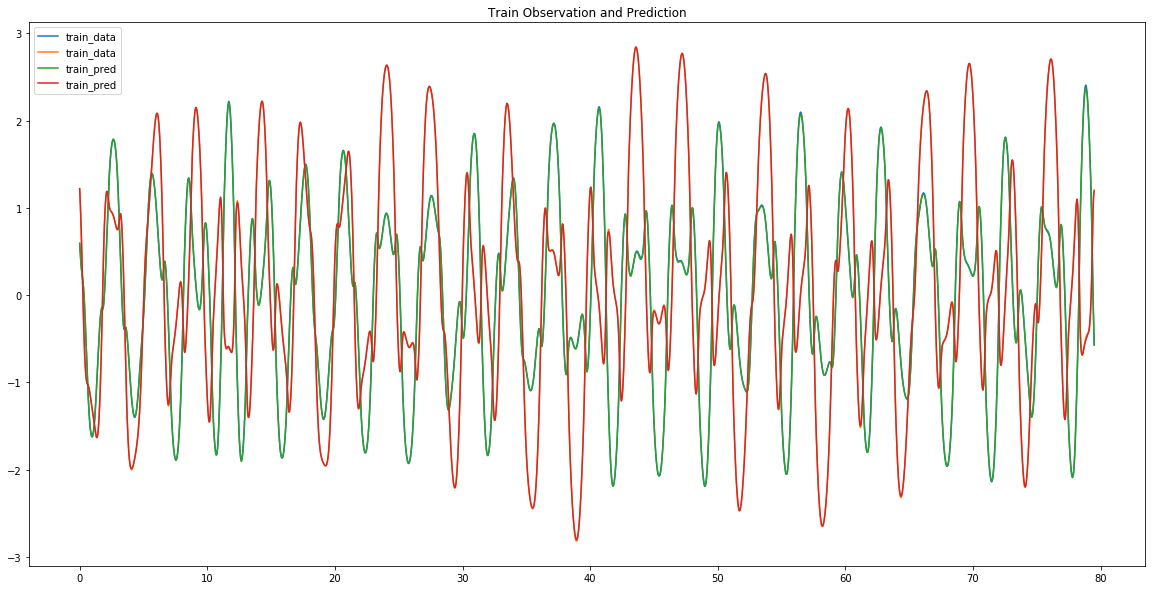

In [16]:
t_train = np.arange(0, len(y_train)*dt, dt)
plt.figure(figsize=(20,10))
plt.plot(t_train, y_train[:], label='train_data')
plt.plot(t_train, train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()